In [54]:
#前処理後のindex作るための処理
import os
import elasticsearch as es
import math
import numpy as np
from itertools import chain
import sys
import tensorflow as tf
import matplotlib.pyplot as plt

ES_HOST = "localhost"
escon = es.Elasticsearch(ES_HOST, port=9200)
GACRP_HOME=os.environ['GACRP_HOME']

In [55]:
data=[]
ans = []

# 元データ取得
es_size=10000
es_s_time='2m'
body = {
    "_source":["channelGrouping","visitNumber","isMobile","country","hits","bounces","newVisits","source","medium","isTrueDirect","transactionRevenue"],
    "query": {
      "match_all": {}
    }
  }
  
res=escon.search(index='gacrp_index',body=body,scroll=es_s_time,size=es_size)
es_s_id=res['_scroll_id']
es_s_size=len(res["hits"]["hits"])


In [56]:
#oneHotベクトル化
def setByScroll(res,data,ans):
    for i in range(len(res["hits"]["hits"])):
        row=res["hits"]["hits"][i]["_source"]
        rec=[]

        if row['channelGrouping']=='Display':
            col_channelGrouping=1
        elif row['channelGrouping']=='Social':
            col_channelGrouping=2
        else:
            col_channelGrouping=0
        oneHot_col_channelGrouping=np.eye(2+1)[col_channelGrouping]
        
        col_visitNumber=min(int(row['visitNumber']),5)/5.0 

        if row['isMobile']=="TRUE":
            col_isMobile=1
        else:
            col_isMobile=0

        if row['country']=="United States":
            col_country =1
        elif row['country']=="Canada":
            col_country =2
        elif row['country']=="Japan":
            col_country=3
        else:
            col_country=0
        oneHot_col_country=np.eye(3+1)[col_country]
    
        col_hits=math.log10(int(row['hits'])*1.0)
    
        if row['bounces']=="1":
            col_bounces=1
        else:
            col_bounces=0

        if row['newVisits']== "1":
            col_newVisits=1
        else:
            col_newVisits=0
    
        if row['source']=="mail.googleplex.com" or row['source']=="dfa":
            col_source =1
        elif row['source']=="(direct)":
            col_source=2
        else:
            col_source=0
        oneHot_col_source=np.eye(2+1)[col_source]
        
        if row['medium']=="cpm":
            col_medium=1
        else:
            col_medium=0
        oneHot_col_medium=np.eye(1+1)[col_medium]
    
        if row['isTrueDirect']=="1":
            col_isTrueDirect=1
        else:
            col_isTrueDirect=0
    
        revenue = math.log(int(row['transactionRevenue'])+1)
    
        l=[oneHot_col_channelGrouping,[col_visitNumber],[col_isMobile],oneHot_col_country,[col_hits],[col_bounces],[col_newVisits],oneHot_col_source,oneHot_col_medium,[col_isTrueDirect]]
        data.append(list(chain.from_iterable(l)))
        ans.append(revenue)
    
    return(data,ans)

In [57]:
while(es_s_size>0):
    data,ans=setByScroll(res,data,ans)
    res=escon.scroll(scroll_id=es_s_id,scroll=es_s_time)
    es_s_id=res['_scroll_id']
    es_s_size=len(res["hits"]["hits"])
    print(len(data),len(ans))

datalength=len(data)

(10000, 10000)
(20000, 20000)
(30000, 30000)
(40000, 40000)
(50000, 50000)
(60000, 60000)
(70000, 70000)
(80000, 80000)
(90000, 90000)
(100000, 100000)
(110000, 110000)
(120000, 120000)
(130000, 130000)
(140000, 140000)
(150000, 150000)
(160000, 160000)
(170000, 170000)
(180000, 180000)
(190000, 190000)
(200000, 200000)
(210000, 210000)
(220000, 220000)
(230000, 230000)
(240000, 240000)
(250000, 250000)
(260000, 260000)
(270000, 270000)
(280000, 280000)
(290000, 290000)
(300000, 300000)
(310000, 310000)
(320000, 320000)
(330000, 330000)
(340000, 340000)
(350000, 350000)
(360000, 360000)
(370000, 370000)
(380000, 380000)
(390000, 390000)
(400000, 400000)
(410000, 410000)
(420000, 420000)
(430000, 430000)
(440000, 440000)
(450000, 450000)
(460000, 460000)
(470000, 470000)
(480000, 480000)
(490000, 490000)
(500000, 500000)
(510000, 510000)
(520000, 520000)
(530000, 530000)
(540000, 540000)
(550000, 550000)
(560000, 560000)
(570000, 570000)
(580000, 580000)
(590000, 590000)
(600000, 600000

In [61]:
#tensorflowセットアップ

#print(data[0],ans[0])
#inputData=tf.transpose(data)
debugFlg=False
batch_size=datalength/2
num_elements=18
P=36
num_rows=len(data)
inputData=np.reshape(data,(num_rows,num_elements))
inputAns=np.reshape(ans,(num_rows,1))
x =tf.placeholder("float",[None,num_elements])
y_=tf.placeholder("float",[None,1])

a=tf.Variable( tf.random_uniform([num_elements,1],-1.0,1.0),name="weights")    
w1=tf.Variable( tf.random_uniform([num_elements,P],-1.0,1.0 )  )
w2=tf.Variable( tf.random_uniform([P,1],-1.0,1.0 )  )
#a=tf.Variable( tf.random_uniform([[18]],-1.0,1.0),name="weights")    
#b=tf.Variable(tf.zeros([1,1]),name="intercept")
b=tf.Variable(tf.random_normal([P]),name="intercept")
print("x:",x.shape,"a:",a.shape)
#y=tf.matmul(tf.transpose(a),x)+b
#y=tf.matmul(x,a)
x2=tf.sigmoid(tf.matmul(x,w1))+b
y=tf.matmul(x2,w2)

init = tf.global_variables_initializer()
loss = tf.reduce_sum(tf.square(y_-y))/batch_size
train_step=tf.train.GradientDescentOptimizer(0.01).minimize(loss)


('x:', TensorShape([Dimension(None), Dimension(18)]), 'a:', TensorShape([Dimension(18), Dimension(1)]))


In [62]:
#データ表示用セットアップ
graphLoss=[]
graphStep=[]
graphNum=20
repeatAll=50000

with tf.Session() as sess:
    sess.run(init)
    print('初期状態')
    inpShape=inputData[0:batch_size]
    ansShape=inputAns[0:batch_size]
    #print('誤差' + str(sess.run(loss, feed_dict={x: inputData[0:batch_size], y_: inputAns[0:batch_size]})))
    ##print('誤差' + str(sess.run(loss, feed_dict={x: inpShape, y_: ansShape})))
    #print("weigths: %f, intercept: %f" % (sess.run(a), sess.run(b) ))
    #print("input:",inputAns[batch_size*step+1:batch_size*step+1+batch_size])
    ##print("weigths:",sess.run(a),"intercept:",sess.run(b) )
    
    for step in range(repeatAll):
        if (batch_size*step) %datalength < (batch_size*step+batch_size) %datalength :
            batchInputData= inputData[(batch_size*step)%datalength:(batch_size*step+batch_size)%datalength]
            batchInputAns = inputAns[(batch_size*step)%datalength:(batch_size*step+batch_size)%datalength]
        else:
            batchInputData= inputData[(batch_size*step)%datalength:min( (batch_size*step+batch_size)%datalength,datalength-1 )]
            batchInputAns = inputAns[(batch_size*step)%datalength:min( (batch_size*step+batch_size)%datalength,datalength-1) ]
        sess.run(train_step, feed_dict={x: batchInputData, y_: batchInputAns })
        if (step+1) % (repeatAll/graphNum) == 0:
            print('\nStep: %s' % (step+1))
            print('誤差' + str(sess.run(loss, feed_dict={x: batchInputData, y_: batchInputAns })))
            if debugFlg==True:
                print("weights:",sess.run(a), " intercept: %f" % ( sess.run(b)))
            graphLoss.append( sess.run(loss, feed_dict={x: batchInputData, y_: batchInputAns }) )
            graphStep.append(step)
    #最終状態を表示
    print("weights1:",sess.run(w1),"weights2:",sess.run(w2), " intercept:", sess.run(b))


初期状態

Step: 2500
誤差3.54318

Step: 5000
誤差3.46267

Step: 7500
誤差3.4188

Step: 10000
誤差3.36849

Step: 12500
誤差3.32463

Step: 15000
誤差3.27791

Step: 17500
誤差3.2422

Step: 20000
誤差3.20725

Step: 22500
誤差3.1708

Step: 25000
誤差3.13894

Step: 27500
誤差3.11584

Step: 30000
誤差3.0997

Step: 32500
誤差3.08499

Step: 35000
誤差3.07624

Step: 37500
誤差3.06822

Step: 40000
誤差3.07336

Step: 42500
誤差3.06212

Step: 45000
誤差3.06144

Step: 47500
誤差3.05193

Step: 50000
誤差3.49559
('weights1:', array([[  4.35450315e-01,   2.87870228e-01,  -1.81541705e+00,
          3.83214474e-01,   5.15227355e-02,  -1.09846807e+00,
         -4.29614857e-02,  -6.00130558e-01,   7.30658710e-01,
          3.03699851e-01,   5.68159938e-01,  -1.50456846e-01,
         -1.86840013e-01,  -3.56735617e-01,   7.31956884e-02,
          4.09291595e-01,   6.58774376e-01,   9.14836451e-02,
         -2.72925377e-01,  -8.91567647e-01,  -8.13005090e-01,
         -7.40927517e-01,  -2.58789510e-01,  -9.68283117e-01,
          2.88063049e-01,   1.05

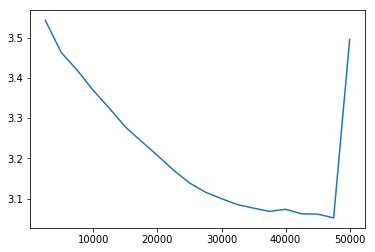

In [63]:
plt.plot(graphStep,graphLoss)